<pre style="text-align: right; width: 100%; font-size: 0.75em; line-height: 0.75em;">
+ ------------------------- + <br>
| 20/04/2025                | <br>
| Héctor Tablero Díaz       | <br>
| Álvaro Martínez Gamo      | <br>
+ ------------------------- + 
</pre>

# **Diffusers**

In [ ]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('./..')

import os

import torch
from torch import Tensor
from torch.utils.data import Subset
from torchvision import datasets
from torchvision.transforms import ToTensor

from image_gen import GenerativeModel
from image_gen.samplers import EulerMaruyama
from image_gen.diffusion import VarianceExploding, VariancePreserving, SubVariancePreserving, BaseDiffusion
from image_gen.noise import LinearNoiseSchedule

from typing import Tuple

import matplotlib.pyplot as plt
from IPython.display import HTML
from image_gen.visualization import display_images, create_evolution_widget

c:\Users\hecto\Desktop\Uni\AAUTO 3\Proyecto\examples\..\image_gen\samplers\euler_maruyama.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


The diffusers determine the way that noise is applied. The default classes are `VarianceExploding`, `VariancePreserving` and `SubVariancePreserving`, with the last 2 being Ornstein-Uhlenbeck processes.

### **Differences Between Diffusers**

We can see the outputs of the different models and compare with each other.

The first step is to get the dataset and define the global variables:

In [2]:
# Set up the common variables
epochs = 250
digit = 3

seed = 42

In [3]:
# Load the dataset
data = datasets.MNIST(
    root='data',
    train=True,
    download=True,
    transform=ToTensor()
)

# Select a subset to speed up the training process
indices_digit = torch.where(data.targets == digit)[0]
data = Subset(data, indices_digit)

For convenience, we will create a function that includes initializing the model, training and generation:

In [ ]:
def diffusion_demo(diffusion_type, num_samples=16, **kwargs):
    """
    Demonstrates the diffusion process for a given diffusion type.
    """
    DIFFUSION_CODES = {
        VarianceExploding: "ve",
        VariancePreserving: "vp-lin",
        SubVariancePreserving: "svp-lin"
    }

    model = GenerativeModel(diffusion=diffusion_type, noise_schedule=LinearNoiseSchedule, sampler=EulerMaruyama)
    
    filename = f'saved_models/mnist_{digit}_{DIFFUSION_CODES[model.diffusion.__class__]}_euler_{epochs}e.pth'

    if os.path.isfile(filename):
        model.load(filename)
    else:
        model.train(data, epochs=epochs)
        # Tip: Save the models for them to be accessible through the dashboard
        model.save(filename)

    samples = model.generate(num_samples, **kwargs)
    display_images(samples)

c:\Users\hecto\Desktop\Uni\AAUTO 3\Proyecto\examples\..\image_gen\base.py:90: UserWarning: VarianceExploding does not require a noise schedule. The provided noise schedule will be ignored.
  warnings.warn(


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 5:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 6:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 7:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 8:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 9:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 10:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 11:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 12:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 13:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 14:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 15:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 16:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 17:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 18:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 19:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 20:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 21:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 22:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 23:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 24:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 25:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 26:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 27:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 28:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 29:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 30:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 31:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 32:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 33:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 34:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 35:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 36:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 37:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 38:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 39:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 40:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 41:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 42:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 43:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 44:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 45:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 46:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 47:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 48:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 49:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 50:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 51:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 52:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 53:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 54:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 55:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 56:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 57:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 58:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 59:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 60:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 61:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 62:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 63:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 64:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 65:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 66:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 67:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 68:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 69:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 70:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 71:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 72:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 73:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 74:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 75:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 76:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 77:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 78:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 79:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 80:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 81:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 82:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 83:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 84:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 85:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 86:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 87:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 88:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 89:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 90:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 91:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 92:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 93:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 94:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 95:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 96:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 97:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 98:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 99:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 100:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 101:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 102:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 103:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 104:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 105:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 106:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 107:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 108:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 109:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 110:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 111:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 112:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 113:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 114:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 115:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 116:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 117:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 118:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 119:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 120:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 121:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 122:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 123:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 124:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 125:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 126:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 127:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 128:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 129:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 130:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 131:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 132:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 133:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 134:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 135:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 136:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 137:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 138:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 139:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 140:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 141:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 142:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 143:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 144:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 145:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 146:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 147:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 148:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 149:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 150:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 151:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 152:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 153:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 154:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 155:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 156:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 157:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 158:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 159:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 160:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 161:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 162:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 163:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 164:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 165:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 166:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 167:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 168:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 169:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 170:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 171:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 172:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 173:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 174:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 175:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 176:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 177:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 178:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 179:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 180:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 181:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 182:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 183:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 184:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 185:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 186:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 187:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 188:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 189:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 190:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 191:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 192:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 193:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 194:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 195:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 196:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 197:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 198:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 199:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 200:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 201:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 202:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 203:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 204:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 205:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 206:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 207:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 208:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 209:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 210:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 211:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 212:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 213:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 214:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 215:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 216:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 217:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 218:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 219:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 220:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 221:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 222:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 223:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 224:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 225:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 226:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 227:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 228:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 229:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 230:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 231:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 232:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 233:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 234:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 235:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 236:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 237:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 238:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 239:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 240:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 241:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 242:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 243:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 244:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 245:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 246:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 247:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 248:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 249:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 250:   0%|          | 0/192 [00:00<?, ?it/s]

Generating:   0%|          | 0/500 [00:00<?, ?it/s]

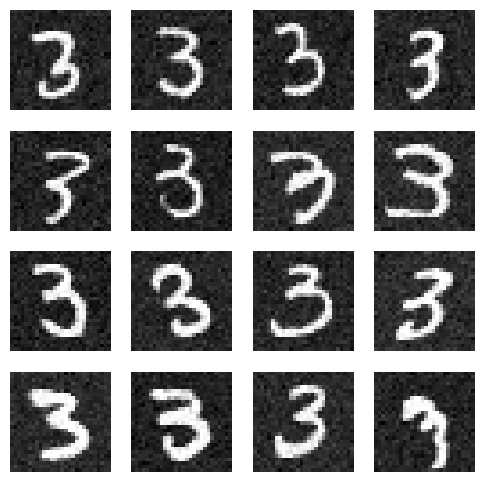

In [5]:
diffusion_demo(VarianceExploding, num_samples=16, seed=seed)

Training:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 5:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 6:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 7:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 8:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 9:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 10:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 11:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 12:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 13:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 14:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 15:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 16:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 17:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 18:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 19:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 20:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 21:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 22:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 23:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 24:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 25:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 26:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 27:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 28:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 29:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 30:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 31:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 32:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 33:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 34:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 35:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 36:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 37:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 38:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 39:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 40:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 41:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 42:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 43:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 44:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 45:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 46:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 47:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 48:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 49:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 50:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 51:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 52:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 53:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 54:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 55:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 56:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 57:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 58:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 59:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 60:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 61:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 62:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 63:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 64:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 65:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 66:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 67:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 68:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 69:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 70:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 71:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 72:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 73:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 74:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 75:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 76:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 77:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 78:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 79:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 80:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 81:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 82:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 83:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 84:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 85:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 86:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 87:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 88:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 89:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 90:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 91:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 92:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 93:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 94:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 95:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 96:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 97:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 98:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 99:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 100:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 101:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 102:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 103:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 104:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 105:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 106:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 107:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 108:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 109:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 110:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 111:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 112:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 113:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 114:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 115:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 116:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 117:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 118:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 119:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 120:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 121:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 122:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 123:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 124:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 125:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 126:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 127:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 128:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 129:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 130:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 131:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 132:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 133:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 134:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 135:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 136:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 137:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 138:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 139:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 140:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 141:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 142:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 143:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 144:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 145:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 146:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 147:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 148:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 149:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 150:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 151:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 152:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 153:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 154:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 155:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 156:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 157:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 158:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 159:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 160:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 161:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 162:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 163:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 164:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 165:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 166:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 167:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 168:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 169:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 170:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 171:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 172:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 173:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 174:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 175:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 176:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 177:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 178:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 179:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 180:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 181:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 182:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 183:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 184:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 185:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 186:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 187:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 188:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 189:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 190:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 191:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 192:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 193:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 194:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 195:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 196:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 197:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 198:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 199:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 200:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 201:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 202:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 203:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 204:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 205:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 206:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 207:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 208:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 209:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 210:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 211:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 212:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 213:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 214:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 215:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 216:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 217:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 218:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 219:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 220:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 221:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 222:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 223:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 224:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 225:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 226:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 227:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 228:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 229:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 230:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 231:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 232:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 233:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 234:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 235:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 236:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 237:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 238:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 239:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 240:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 241:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 242:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 243:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 244:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 245:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 246:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 247:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 248:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 249:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 250:   0%|          | 0/192 [00:00<?, ?it/s]

Generating:   0%|          | 0/500 [00:00<?, ?it/s]

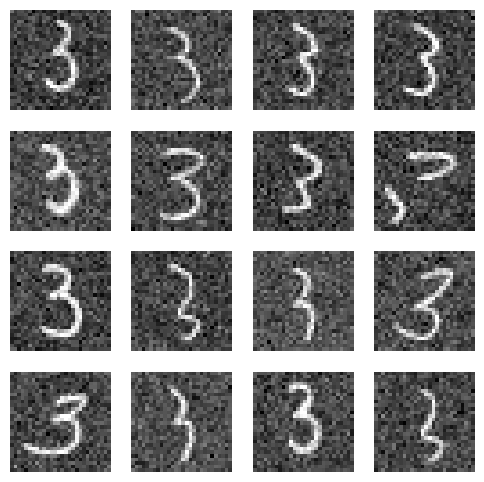

In [6]:
diffusion_demo(VariancePreserving, num_samples=16, seed=seed)

Training:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 5:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 6:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 7:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 8:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 9:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 10:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 11:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 12:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 13:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 14:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 15:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 16:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 17:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 18:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 19:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 20:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 21:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 22:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 23:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 24:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 25:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 26:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 27:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 28:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 29:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 30:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 31:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 32:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 33:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 34:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 35:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 36:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 37:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 38:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 39:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 40:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 41:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 42:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 43:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 44:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 45:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 46:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 47:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 48:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 49:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 50:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 51:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 52:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 53:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 54:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 55:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 56:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 57:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 58:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 59:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 60:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 61:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 62:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 63:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 64:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 65:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 66:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 67:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 68:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 69:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 70:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 71:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 72:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 73:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 74:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 75:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 76:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 77:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 78:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 79:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 80:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 81:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 82:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 83:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 84:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 85:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 86:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 87:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 88:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 89:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 90:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 91:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 92:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 93:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 94:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 95:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 96:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 97:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 98:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 99:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 100:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 101:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 102:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 103:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 104:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 105:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 106:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 107:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 108:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 109:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 110:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 111:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 112:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 113:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 114:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 115:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 116:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 117:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 118:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 119:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 120:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 121:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 122:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 123:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 124:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 125:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 126:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 127:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 128:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 129:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 130:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 131:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 132:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 133:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 134:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 135:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 136:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 137:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 138:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 139:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 140:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 141:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 142:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 143:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 144:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 145:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 146:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 147:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 148:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 149:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 150:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 151:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 152:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 153:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 154:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 155:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 156:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 157:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 158:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 159:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 160:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 161:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 162:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 163:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 164:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 165:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 166:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 167:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 168:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 169:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 170:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 171:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 172:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 173:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 174:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 175:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 176:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 177:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 178:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 179:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 180:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 181:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 182:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 183:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 184:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 185:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 186:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 187:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 188:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 189:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 190:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 191:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 192:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 193:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 194:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 195:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 196:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 197:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 198:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 199:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 200:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 201:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 202:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 203:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 204:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 205:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 206:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 207:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 208:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 209:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 210:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 211:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 212:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 213:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 214:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 215:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 216:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 217:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 218:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 219:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 220:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 221:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 222:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 223:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 224:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 225:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 226:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 227:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 228:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 229:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 230:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 231:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 232:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 233:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 234:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 235:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 236:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 237:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 238:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 239:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 240:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 241:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 242:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 243:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 244:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 245:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 246:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 247:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 248:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 249:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 250:   0%|          | 0/192 [00:00<?, ?it/s]

Generating:   0%|          | 0/500 [00:00<?, ?it/s]

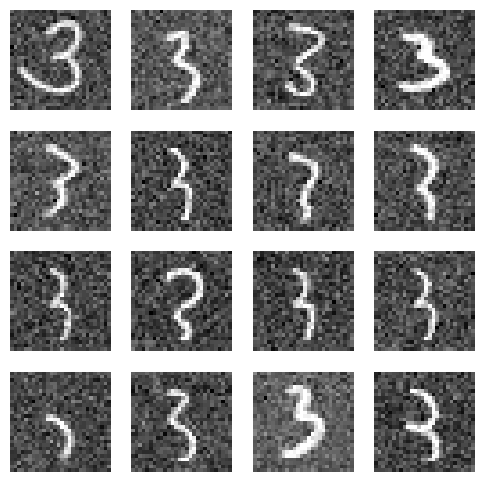

In [7]:
diffusion_demo(SubVariancePreserving, num_samples=16, seed=seed)

As it can be seen from these examples, `VarianceExploding` is the fastest to train, followed by `VariancePreserving` and lastly `SubVariancePreserving`, which requires a lot more epochs to produce good results.

### **Creating Custom Classes**

Custom diffusers can be created by inheriting from `BaseDiffusion`. The methods that must be implemented are `forward_sde` and `forward_process`.

It is currently not supported to load models with a custom diffuser, but it is highly recommended that they implement a `config` method for future updates.

In [ ]:
class CustomDiffuser(BaseDiffusion):
    def forward_sde(self, x: Tensor, t: Tensor) -> Tuple[Tensor, Tensor]:
        ...

    def forward_process(self, x0: Tensor, t: Tensor) -> Tuple[Tensor, Tensor]:
        ...